<a href="https://colab.research.google.com/github/holdless/Colab/blob/master/colab_cat_and_dog_try%2C_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

load data

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(val_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(val_dir, 'dogs')  # directory with our validation dog pictures


understand data

In [4]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


some hyper parameters:

In [5]:
IMG_HEIGHT = 150
IMG_WIDTH = 150

embedding_dims = 4 #32.. don't set too high
batch_size = 100 #128.. must be smaller than dataset size... and可整除dataset data number, or metrics will fail to output
epochs = 100

Data preparation

In [6]:
#image data generator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

# train data generator
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
# valid data generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

In [7]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        #ax.imshow(img[:,:,0], cmap='gray') #show gray level pic
        ax.axis('off')
    plt.tight_layout()
    plt.show()

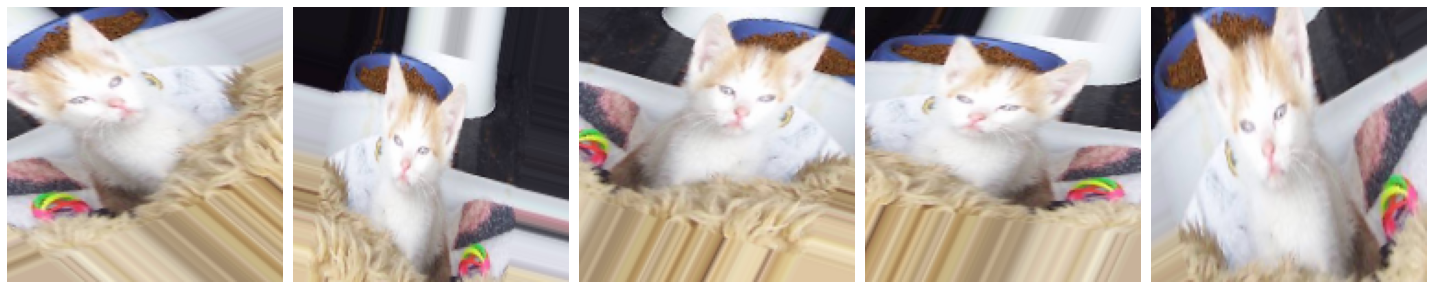

In [8]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

<Figure size 432x288 with 0 Axes>

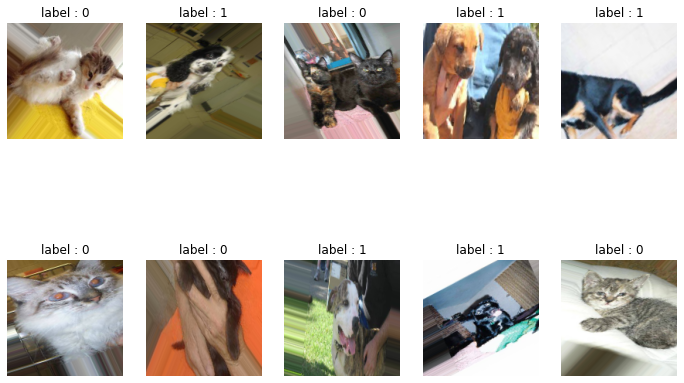

In [9]:
# show what batch images after augmentation look like...
imgs, labels = next(train_data_gen)
ncols = 5
nrows = 2

plt.suptitle("faces in training dataset")
plt.figure(figsize = (12,8))
for i,(img,label) in enumerate(zip(imgs,labels)):
    if i > 9 :
        break
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img.reshape(IMG_HEIGHT,IMG_WIDTH,3), cmap = 'binary')
#    plt.imshow(img.reshape(IMG_HEIGHT,IMG_WIDTH), cmap = 'gray')
    plt.title("label : " + str(label.astype(np.int64)))
    plt.axis("off")
plt.show()

In [10]:
# prepare augment generator for triplet loss function input arguments
def augmentation_generator(input_gen, batch_size, embedding_dims):
    dummy_y = np.zeros((batch_size, embedding_dims + 1))
    for img, label in input_gen: 
#        a = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
        yield [img ,label.astype(np.int64)], dummy_y

In [11]:
train_aug = augmentation_generator(train_data_gen, batch_size, embedding_dims)
valid_aug = augmentation_generator(val_data_gen, batch_size, embedding_dims)

build model

In [12]:
def _cn_bn_relu(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same"):
    
    def f(input_x):
        
        x = input_x
        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding,
                          kernel_initializer = "he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        return x
    return f

def _dn_bn_relu(units = 256):
    def f(input_x):
        
        x = input_x
        x = tf.keras.layers.Dense(units = units)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        
        return x
    return f
    
def build_model(image_input, embedding_dims):
    # original conv2d fileter setting = 64 for all!
    x = _cn_bn_relu(filters = 64, kernel_size = (3,3))(image_input)
    x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
    x = _cn_bn_relu(filters = 64, kernel_size = (3,3))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(x)
#    x = tf.keras.layers.Dropout(0.35)(x) #
    x = tf.keras.layers.Flatten()(x)
    x = _dn_bn_relu(units = 256)(x)
    x = _dn_bn_relu(units = 128)(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = _dn_bn_relu(units = 64)(x)
    x = tf.keras.layers.Dense(units = embedding_dims, name = "embedding_layer")(x)
    # 2020.6.23 hiroshi: add l-2 normalization for triplet loss input argument
    x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    
    return x

#image_input = tf.keras.layers.Input(shape = next(train_aug)[0][0].shape, name = "image_input")
image_input = tf.keras.layers.Input(shape = next(train_aug)[0][0][0].shape, name = "image_input")
label_input = tf.keras.layers.Input(shape = (1,), name = "label_input")

base_model = build_model(image_input, embedding_dims)
output = tf.keras.layers.concatenate([label_input, base_model])

model = tf.keras.models.Model(inputs = [image_input, label_input], outputs = [output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 150, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
next(train_aug)[0][0][0].shape

(150, 150, 3)

Training embedding model

In [14]:
# define triplet loss function
def triplet_loss(y_true, y_pred, margin = 1.2):
    
    del y_true
    
    labels = y_pred[:,:1]
    labels = tf.dtypes.cast(labels, tf.int32)
    labels = tf.reshape(labels, (tf.shape(labels)[0],))
    
    embeddings = y_pred[:,1:]
    #return tfa.losses.triplet_semihard_loss(labels = labels, embeddings = embeddings, margin = margin)
    return tfa.losses.triplet_semihard_loss(y_true=labels, y_pred=embeddings, margin=margin)

In [15]:
import tensorflow_addons as tfa

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=triplet_loss,
    metrics=['Accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.5, mode = 'min', verbose = 1, min_lr = 1e-6)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min')
steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size

#epochs = 10

history = model.fit(train_aug, steps_per_epoch = steps_per_epoch,
                              epochs = epochs, verbose = 1,
                              validation_data = valid_aug, 
                              validation_steps = validation_steps,
                              callbacks = [reduce_lr,es],
                              shuffle = True)

Epoch 1/100
20/20 [==============================] - 16s 804ms/step - loss: 1.1288 - accuracy: 0.0981 - val_loss: 1.1985 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 16s 812ms/step - loss: 1.1239 - accuracy: 0.1012 - val_loss: 1.1870 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 16s 809ms/step - loss: 1.1227 - accuracy: 0.0994 - val_loss: 1.1456 - val_accuracy: 0.1006 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 16s 815ms/step - loss: 1.1210 - accuracy: 0.1015 - val_loss: 1.1378 - val_accuracy: 0.0960 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 16s 820ms/step - loss: 1.1153 - accuracy: 0.0985 - val_loss: 1.1570 - val_accuracy: 0.0992 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 16s 812ms/step - loss: 1.1160 - accuracy: 0.1003 - val_loss: 1.1517 - val_accuracy: 0.1022 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - ETA: 

In [16]:
history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51]

show training info#

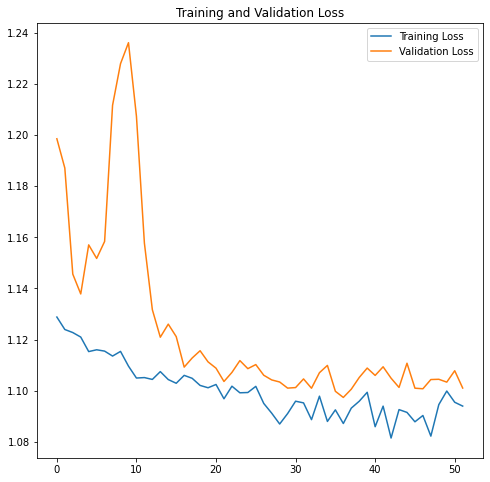

In [17]:
#acc = history.history['Accuracy']
#val_acc = history.history['val_Accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = history.epoch
plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

#plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
activation_5 (Activation)    (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256 

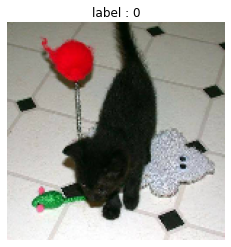

In [18]:
#Transfer the weights from original model to embedding model

image_input = tf.keras.layers.Input(shape = next(train_aug)[0][0][0].shape)
embedding_output = build_model(image_input, embedding_dims = embedding_dims)
embedding_model = tf.keras.models.Model(inputs = [image_input], outputs = [embedding_output])

for idx in range(1,18):
    target_layer = embedding_model.layers[idx]
    source_layer = model.layers[idx]
    target_layer.set_weights(source_layer.get_weights())
    
embedding_model.layers[-1].set_weights(model.layers[-2].get_weights())

embedding_model.summary()


# ### load all train and valid data

# In[ ]:


image_gen = ImageDataGenerator(rescale=1./255)
train_all_gen = image_gen.flow_from_directory(batch_size=total_train,
                                                     directory=train_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
val_all_gen = image_gen.flow_from_directory(batch_size=total_val,
                                                     directory=val_dir,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
all_train_img, all_train_label = next(train_all_gen)
all_val_img, all_val_label = next(val_all_gen)

# example to show an image...
imgType = 'val'
idx = 2
imgNameStr = 'all_' + imgType + "_img[idx]"
plt.imshow(eval(imgNameStr).reshape(IMG_HEIGHT,IMG_WIDTH,3), cmap = 'binary')
plt.title("label : " + str(all_train_label[idx].astype(np.int64)))
plt.axis("off")
plt.show()

visualization using t-sne

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy s

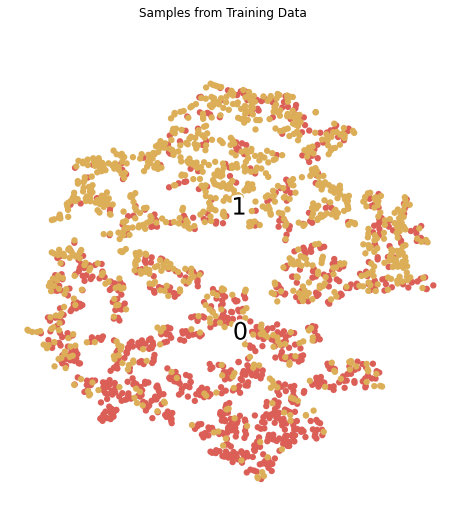

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


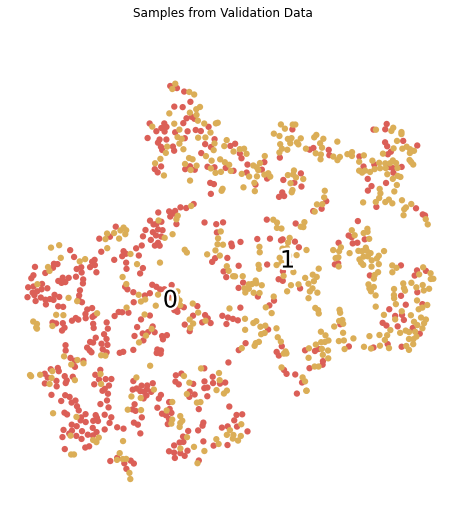

In [19]:
from sklearn.manifold import TSNE



import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

train_x_embeddings = embedding_model.predict(all_train_img)
valid_x_embeddings = embedding_model.predict(all_val_img)

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(train_x_embeddings)
scatter(train_tsne_embeds, all_train_label, "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(valid_x_embeddings)
scatter(eval_tsne_embeds, all_val_label, "Samples from Validation Data")
